In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    fasterrcnn_mobilenet_v3_large_fpn,
)
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!tar -xvzf /content/drive/MyDrive/nycu-hw2-data.tar.gz -C /content/

串流輸出內容已截斷至最後 5000 行。
nycu-hw2-data/train/28414.png
nycu-hw2-data/train/28415.png
nycu-hw2-data/train/28416.png
nycu-hw2-data/train/28417.png
nycu-hw2-data/train/28418.png
nycu-hw2-data/train/28419.png
nycu-hw2-data/train/28420.png
nycu-hw2-data/train/28421.png
nycu-hw2-data/train/28422.png
nycu-hw2-data/train/28423.png
nycu-hw2-data/train/28424.png
nycu-hw2-data/train/28425.png
nycu-hw2-data/train/28426.png
nycu-hw2-data/train/28427.png
nycu-hw2-data/train/28428.png
nycu-hw2-data/train/28429.png
nycu-hw2-data/train/28430.png
nycu-hw2-data/train/28431.png
nycu-hw2-data/train/28432.png
nycu-hw2-data/train/28433.png
nycu-hw2-data/train/28434.png
nycu-hw2-data/train/28435.png
nycu-hw2-data/train/28436.png
nycu-hw2-data/train/28437.png
nycu-hw2-data/train/28438.png
nycu-hw2-data/train/28439.png
nycu-hw2-data/train/28440.png
nycu-hw2-data/train/28441.png
nycu-hw2-data/train/28442.png
nycu-hw2-data/train/28443.png
nycu-hw2-data/train/28444.png
nycu-hw2-data/train/28445.png
nycu-hw2-data/train

In [4]:
import json

json_path = "/content/nycu-hw2-data/train.json"

with open(json_path, 'r') as f:
    data = json.load(f)

print(data.keys())

print("\nimages:")
print(data["images"][:2])

print("\nannotations:")
print(data["annotations"][:2])

print("\ncategories:")
print(data["categories"])

dict_keys(['images', 'annotations', 'categories'])

images:
[{'id': 1, 'file_name': '1.png', 'height': 25, 'width': 59}, {'id': 2, 'file_name': '2.png', 'height': 35, 'width': 91}]

annotations:
[{'id': 1, 'image_id': 1, 'bbox': [19.0, 2.0, 9.0, 21.0], 'category_id': 10, 'area': 189.0, 'iscrowd': 0}, {'id': 2, 'image_id': 1, 'bbox': [29.0, 1.0, 10.0, 21.0], 'category_id': 1, 'area': 210.0, 'iscrowd': 0}]

categories:
[{'id': 1, 'name': '0'}, {'id': 2, 'name': '1'}, {'id': 3, 'name': '2'}, {'id': 4, 'name': '3'}, {'id': 5, 'name': '4'}, {'id': 6, 'name': '5'}, {'id': 7, 'name': '6'}, {'id': 8, 'name': '7'}, {'id': 9, 'name': '8'}, {'id': 10, 'name': '9'}]


In [18]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
])


class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)

        self.image_ids = [img['id'] for img in self.annotations['images']]
        self.image_id_to_filename = {
            img['id']: img['file_name']
            for img in self.annotations['images']
        }

        self.image_to_anns = {}
        for ann in self.annotations['annotations']:
            img_id = ann['image_id']
            self.image_to_anns.setdefault(img_id, []).append(ann)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(
            self.image_dir, self.image_id_to_filename[image_id]
        )
        img = Image.open(img_path).convert("RGB")

        anns = self.image_to_anns.get(image_id, [])
        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

In [19]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import random

In [20]:
# Load dataset

image_dir = "/content/nycu-hw2-data/train"
annotation_file = "/content/nycu-hw2-data/train.json"

train_dataset = CustomDataset(
    image_dir=image_dir,
    annotation_file=annotation_file,
    transforms=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

In [8]:
from collections import Counter

label_counter = Counter()

for imgs, targets in train_loader:
    for target in targets:
        labels = target['labels'].tolist()
        label_counter.update(labels)

print("每個類別的標註數量：")
for label, count in sorted(label_counter.items()):
    print(f"Label {label}: {count} 個")

每個類別的標註數量：
Label 1: 4454 個
Label 2: 12463 個
Label 3: 9544 個
Label 4: 7662 個
Label 5: 6700 個
Label 6: 6184 個
Label 7: 5194 個
Label 8: 4999 個
Label 9: 4558 個
Label 10: 4202 個


In [21]:
total_len = len(train_dataset)
print(f"length of train_dataset：{total_len}")

length of train_dataset：30062


In [10]:
val_image_dir = "/content/nycu-hw2-data/valid"
val_json_path = "/content/nycu-hw2-data/valid.json"

val_dataset = CustomDataset(
    val_image_dir,
    val_json_path,
    transforms=transforms.ToTensor()
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

In [11]:
model_resnet = fasterrcnn_resnet50_fpn(pretrained=True)
model_mobilenet = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 104MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None

In [12]:
print("ResNet50 Anchor Sizes:",
      model_resnet.rpn.anchor_generator.sizes)
print("ResNet50 Anchor Ratios:",
      model_resnet.rpn.anchor_generator.aspect_ratios)

print("MobileNetV3 Anchor Sizes:",
      model_mobilenet.rpn.anchor_generator.sizes)
print("MobileNetV3 Anchor Ratios:",
      model_mobilenet.rpn.anchor_generator.aspect_ratios)

ResNet50 Anchor Sizes: ((32,), (64,), (128,), (256,), (512,))
ResNet50 Anchor Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
MobileNetV3 Anchor Sizes: ((32, 64, 128, 256, 512), (32, 64, 128, 256, 512), (32, 64, 128, 256, 512))
MobileNetV3 Anchor Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))


In [14]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import (
    TwoMLPHead, FastRCNNPredictor, MultiScaleRoIAlign
)

model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

num_classes = 10 + 1

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.roi_heads.box_roi_pool = MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],
    output_size=(7, 7),
    sampling_ratio=3
)

model.rpn.anchor_generator = AnchorGenerator(
    sizes=(
        (4, 8, 16, 32, 64),
        (8, 16, 32, 64, 128),
        (16, 32, 64, 128, 256)
    ),
    aspect_ratios=(
        (0.5, 1.0, 2.0),
        (0.5, 1.0, 2.0),
        (0.5, 1.0, 2.0)
    )
)

In [15]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=3)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=11, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=44, bias=True)
  )
)

In [16]:
print("Anchor Sizes:", model.rpn.anchor_generator.sizes)
print("Anchor Ratios:", model.rpn.anchor_generator.aspect_ratios)

Anchor Sizes: ((4, 8, 16, 32, 64), (8, 16, 32, 64, 128), (16, 32, 64, 128, 256))
Anchor Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 18,917,458


In [ ]:
!pip install torchmetrics

In [ ]:
import torchvision.ops as ops

def evaluate_detection_accuracy(outputs, targets, iou_threshold=0.5):
    tp = 0
    fn = 0
    box_accuracy = []

    for output, target in zip(outputs, targets):
        pred_boxes = output['boxes']
        pred_labels = output['labels']
        gt_boxes = target['boxes']
        gt_labels = target['labels']

        if len(pred_boxes) == 0:
            fn += len(gt_boxes)
            continue

        ious = ops.box_iou(pred_boxes, gt_boxes)
        matched_gt = set()

        for pred_idx, pred_label in enumerate(pred_labels):
            iou_values = ious[pred_idx]
            max_iou, max_idx = iou_values.max(0)
            if max_iou >= iou_threshold and pred_label == gt_labels[max_idx] and max_idx.item() not in matched_gt:
                tp += 1
                matched_gt.add(max_idx.item())
                box_accuracy.append(max_iou.item())
            else:
                box_accuracy.append(0)

        fn += len(gt_boxes) - len(matched_gt)

    accuracy = tp / (tp + fn + 1e-6)
    mean_box_accuracy = torch.tensor(box_accuracy).mean().item() if box_accuracy else 0.0

    return accuracy, mean_box_accuracy

In [ ]:
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import DataLoader

map_metric = MeanAveragePrecision()

def evaluate_mAP(model, val_loader):
    model.eval()
    predictions = []
    targets = []

    pbar = tqdm(val_loader, desc="Evaluating", leave=False)

    for images, target in pbar:
        images = [img.to(device) for img in images]
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        with torch.no_grad():
            output = model(images)

        predictions.extend(output)
        targets.extend(target)

        pbar.set_postfix({"Batch Size": len(images)})

    map_metric.update(predictions, targets)
    return map_metric.compute()

In [ ]:
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 8
patience = 3
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        pbar.set_postfix(loss=losses.item())

        del images, targets, loss_dict

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        all_outputs = []
        all_targets = []
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            all_outputs.extend(outputs)
            all_targets.extend(targets)

        acc, box_acc = evaluate_detection_accuracy(all_outputs, all_targets)

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, "
          f"Val Accuracy = {acc:.4f}, Box IoU = {box_acc:.4f}\n")

    mAP = evaluate_mAP(model, val_loader)
    print(f"mAP: {mAP}")

    if box_acc > best_acc:
        best_acc = box_acc
        epochs_no_improve = 0
        print("Validation accuracy improved. Saving model...\n")
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).\n")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

print("Training and validation complete!")

Epoch 1/8


Epoch 1: Train Loss = 0.6395, Val Accuracy = 0.9530, Box IoU = 0.3255



mAP: {'map': tensor(0.4319), 'map_50': tensor(0.9085), 'map_75': tensor(0.3188), 'map_small': tensor(0.4227), 'map_medium': tensor(0.4708), 'map_large': tensor(0.5591), 'mar_1': tensor(0.4896), 'mar_10': tensor(0.5284), 'mar_100': tensor(0.5284), 'mar_small': tensor(0.5194), 'mar_medium': tensor(0.5619), 'mar_large': tensor(0.5681), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
Validation accuracy improved. Saving model...

Epoch 2/8


Epoch 2: Train Loss = 0.7735, Val Accuracy = 0.9571, Box IoU = 0.3356



mAP: {'map': tensor(0.4326), 'map_50': tensor(0.9106), 'map_75': tensor(0.3246), 'map_small': tensor(0.4229), 'map_medium': tensor(0.4701), 'map_large': tensor(0.5524), 'mar_1': tensor(0.4926), 'mar_10': tensor(0.5312), 'mar_100': tensor(0.5312), 'mar_small': tensor(0.5236), 'mar_medium': tensor(0.5591), 'mar_large': tensor(0.5780), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
Validation accuracy improved. Saving model...

Epoch 3/8


Epoch 3: Train Loss = 0.8199, Val Accuracy = 0.9538, Box IoU = 0.3634



mAP: {'map': tensor(0.4340), 'map_50': tensor(0.9123), 'map_75': tensor(0.3276), 'map_small': tensor(0.4233), 'map_medium': tensor(0.4740), 'map_large': tensor(0.5414), 'mar_1': tensor(0.4929), 'mar_10': tensor(0.5312), 'mar_100': tensor(0.5312), 'mar_small': tensor(0.5230), 'mar_medium': tensor(0.5619), 'mar_large': tensor(0.5791), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
Validation accuracy improved. Saving model...

Epoch 4/8


Epoch 4: Train Loss = 0.8441, Val Accuracy = 0.9545, Box IoU = 0.4087



mAP: {'map': tensor(0.4323), 'map_50': tensor(0.9136), 'map_75': tensor(0.3215), 'map_small': tensor(0.4218), 'map_medium': tensor(0.4719), 'map_large': tensor(0.5494), 'mar_1': tensor(0.4924), 'mar_10': tensor(0.5301), 'mar_100': tensor(0.5301), 'mar_small': tensor(0.5214), 'mar_medium': tensor(0.5623), 'mar_large': tensor(0.5839), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
Validation accuracy improved. Saving model...

Epoch 5/8


Epoch 5: Train Loss = 0.8538, Val Accuracy = 0.9545, Box IoU = 0.3890



mAP: {'map': tensor(0.4321), 'map_50': tensor(0.9150), 'map_75': tensor(0.3209), 'map_small': tensor(0.4212), 'map_medium': tensor(0.4719), 'map_large': tensor(0.5454), 'mar_1': tensor(0.4924), 'mar_10': tensor(0.5295), 'mar_100': tensor(0.5295), 'mar_small': tensor(0.5211), 'mar_medium': tensor(0.5607), 'mar_large': tensor(0.5841), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
No improvement for 1 epoch(s).

Epoch 6/8


Epoch 6: Train Loss = 0.8606, Val Accuracy = 0.9522, Box IoU = 0.4651



mAP: {'map': tensor(0.4327), 'map_50': tensor(0.9160), 'map_75': tensor(0.3209), 'map_small': tensor(0.4220), 'map_medium': tensor(0.4728), 'map_large': tensor(0.5424), 'mar_1': tensor(0.4929), 'mar_10': tensor(0.5298), 'mar_100': tensor(0.5298), 'mar_small': tensor(0.5213), 'mar_medium': tensor(0.5614), 'mar_large': tensor(0.5841), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
Validation accuracy improved. Saving model...

Epoch 7/8


Epoch 7: Train Loss = 0.8617, Val Accuracy = 0.9526, Box IoU = 0.3868



mAP: {'map': tensor(0.4321), 'map_50': tensor(0.9165), 'map_75': tensor(0.3187), 'map_small': tensor(0.4217), 'map_medium': tensor(0.4729), 'map_large': tensor(0.5375), 'mar_1': tensor(0.4926), 'mar_10': tensor(0.5294), 'mar_100': tensor(0.5294), 'mar_small': tensor(0.5205), 'mar_medium': tensor(0.5625), 'mar_large': tensor(0.5842), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
No improvement for 1 epoch(s).

Epoch 8/8


Epoch 8: Train Loss = 0.8725, Val Accuracy = 0.9571, Box IoU = 0.4287



mAP: {'map': tensor(0.4334), 'map_50': tensor(0.9177), 'map_75': tensor(0.3204), 'map_small': tensor(0.4229), 'map_medium': tensor(0.4735), 'map_large': tensor(0.5398), 'mar_1': tensor(0.4936), 'mar_10': tensor(0.5303), 'mar_100': tensor(0.5303), 'mar_small': tensor(0.5217), 'mar_medium': tensor(0.5624), 'mar_large': tensor(0.5867), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}
No improvement for 2 epoch(s).

Training and validation complete!


In [ ]:
#model.load_state_dict(torch.load("best_model.pth", map_location=device))

<All keys matched successfully>

In [ ]:
mAP = evaluate_mAP(model, val_loader)
print(f"mAP: {mAP}")

mAP: {'map': tensor(0.4345), 'map_50': tensor(0.9187), 'map_75': tensor(0.3223), 'map_small': tensor(0.4242), 'map_medium': tensor(0.4742), 'map_large': tensor(0.5423), 'mar_1': tensor(0.4944), 'mar_10': tensor(0.5311), 'mar_100': tensor(0.5311), 'mar_small': tensor(0.5226), 'mar_medium': tensor(0.5624), 'mar_large': tensor(0.5887), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.int32)}


In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, image_list, transforms=None):
        self.image_dir = image_dir
        self.image_list = image_list
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, image_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms:
            img = self.transforms(img)

        return img, image_name

    def __len__(self):
        return len(self.image_list)


In [ ]:
import re

image_dir = "nycu-hw2-data/test"
image_list = sorted(os.listdir(image_dir), key=lambda x: int(re.sub('\D', '', x)))

print("Sorted image_list (first 10 items):", image_list[100:150])

Sorted image_list (first 10 items): ['101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '150.png']


In [ ]:
import torchvision.transforms as T
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import json

# === Test Transforms ===
test_transforms = T.Compose([
    T.ToTensor()
])

# === Create DataLoader ===
test_dataset = TestDataset(image_dir=image_dir, image_list=image_list, transforms=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# === Inference + Save Results ===
model.eval()
results = []

with torch.no_grad():
    for imgs, img_names in tqdm(test_loader):
        # Convert imgs (tuple) to list before feeding into the model (required by Faster R-CNN)
        imgs = list(img.to(device) for img in imgs)

        outputs = model(imgs)  # batch input, batch output (list of dicts)

        for output, img_name in zip(outputs, img_names):
            for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                if score < 0.5:
                    continue

                x1, y1, x2, y2 = box.cpu().tolist()
                width = x2 - x1
                height = y2 - y1

                image_id = int(img_name.replace(".png", ""))
                results.append({
                    "image_id": image_id,
                    "bbox": [x1, y1, width, height],
                    "score": score.item(),
                    "category_id": label.item()  # Modify here if you have custom label mapping
                })

# === Save as JSON ===
with open("pred.json", "w") as f:
    json.dump(results, f)

100%|██████████| 3267/3267 [04:29<00:00, 12.14it/s]


In [ ]:
import csv

csv_results = []
image_id_counter = 1

test_dataset = TestDataset(image_dir=image_dir, image_list=image_list, transforms=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for imgs, img_names in tqdm(test_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for output, img_name in zip(outputs, img_names):
            # Store all detected digits
            detected_digits = []

            if len(output["scores"]) == 0 or output["scores"].max().item() < 0.5:
                pred_label = -1
            else:
                # Process each box
                for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                    if score >= 0.5:  # Only process if confidence score is above 0.5
                        x_min = box[0].item()  # box[0] is x_min, the x-coordinate of the top-left corner
                        detected_digits.append((x_min, str(label.item() - 1)))  # Save x_min and label

            # Sort by x_min (from left to right)
            detected_digits.sort(key=lambda x: x[0])  # x[0] is x_min

            # If digits are detected, combine them into a continuous number
            if detected_digits:
                combined_number = ''.join([digit[1] for digit in detected_digits])  # Combine into a string
            else:
                combined_number = '-1'  # No digits detected

            image_id = img_name.replace(".png", "")
            csv_results.append({
                "image_id": image_id,  # You can replace this with image_id
                "pred_label": combined_number
            })

            image_id_counter += 1

# === Write to CSV ===
with open("pred.csv", mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["image_id", "pred_label"])
    writer.writeheader()
    writer.writerows(csv_results)

100%|██████████| 13068/13068 [05:00<00:00, 43.49it/s]


In [ ]:
from collections import Counter

csv_results = []
label_counter = Counter()
image_id_counter = 1

test_dataset = TestDataset(image_dir=image_dir, image_list=image_list, transforms=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for imgs, img_names in tqdm(test_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for output, img_name in zip(outputs, img_names):
            detected_digits = []

            if len(output["scores"]) == 0 or output["scores"].max().item() < 0.5:
                combined_number = '-1'
            else:
                for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                    if score >= 0.5:
                        x_min = box[0].item()
                        digit = str(label.item())
                        detected_digits.append((x_min, digit))
                        label_counter.update([digit])

            image_id_counter += 1


print("Detection statistics for each digit:")
for digit, count in sorted(label_counter.items()):
    print(f"Label {digit}: {count} times")

100%|██████████| 13068/13068 [05:00<00:00, 43.53it/s]

各數字的偵測次數統計：
Label 1: 1629 次
Label 10: 1634 次
Label 2: 4192 次
Label 3: 3680 次
Label 4: 2781 次
Label 5: 2172 次
Label 6: 1982 次
Label 7: 1859 次
Label 8: 1623 次
Label 9: 1605 次


In [ ]:
import os
from PIL import Image

def calculate_average_resolution(folder_path):
    widths = []
    heights = []
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Skipping image {filename}, error: {e}")

    if not widths:
        print("No images found.")
        return None

    avg_width = sum(widths) / len(widths)
    avg_height = sum(heights) / len(heights)

    print(f"Number of images: {len(widths)}")
    print(f"Average width: {avg_width:.2f} px")
    print(f"Average height: {avg_height:.2f} px")

    return avg_width, avg_height

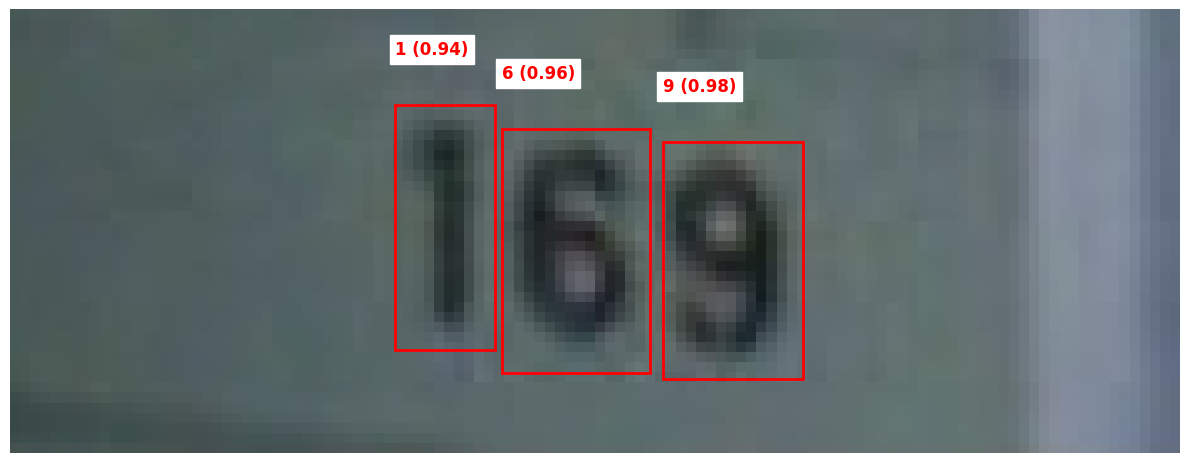

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as T

# 設定路徑與模型
image_path = "nycu-hw2-data/test/1013.png"  # 換成你想看的圖片檔名
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 圖片前處理
transform = T.Compose([T.ToTensor()])
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).to(device)

# 模型推論
with torch.no_grad():
    prediction = model([image_tensor])[0]

# 繪圖
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# 畫出每個 bounding box
for box, score, label in zip(prediction["boxes"], prediction["scores"], prediction["labels"]):
    if score < 0.5:
        continue  # 忽略低信心的偵測

    x1, y1, x2, y2 = box.cpu().numpy()
    width = x2 - x1
    height = y2 - y1

    # 加上框線
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                             edgecolor="red", facecolor="none")
    ax.add_patch(rect)

    # 加上標籤（數字）
    label_text = str(label.item() -1)
    ax.text(x1, y1 - 5, f'{label_text} ({score:.2f})', color='red',
            fontsize=12, weight='bold', backgroundcolor='white')

plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
calculate_average_resolution("nycu-hw2-data/test/")

圖片數量：13068
平均寬度：172.58 px
平均高度：71.57 px


(172.58348637894093, 71.56649831649831)

In [ ]:
calculate_average_resolution("nycu-hw2-data/train/")

圖片數量：30062
平均寬度：128.22 px
平均高度：57.17 px


(128.21987891690506, 57.16978244960415)

In [ ]:
calculate_average_resolution("nycu-hw2-data/valid/")

圖片數量：3340
平均寬度：128.87 px
平均高度：57.60 px


(128.87095808383233, 57.60209580838323)